# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: CodeChallenge: Linear GAN with FMNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the data

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 7803412.05it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 137311.10it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2679803.77it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21570706.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
# classes2keep = [ 'Trouser','Sneaker','Pullover' ]
classes2keep = [ 'Trouser','Sneaker', 'Sandal'  ]



# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
  classidx = dataset.classes.index(classes2keep[i])
  images2use = torch.cat( (images2use,torch.where(dataset.targets==classidx)[0]), 0).type(torch.long)
  print(f'Added class {classes2keep[i]} (index {classidx})')

# now select just those images

# transform to dataloaders
batchsize   = 100
sampler     = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset,sampler=sampler,batch_size=batchsize,drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Sandal (index 5)


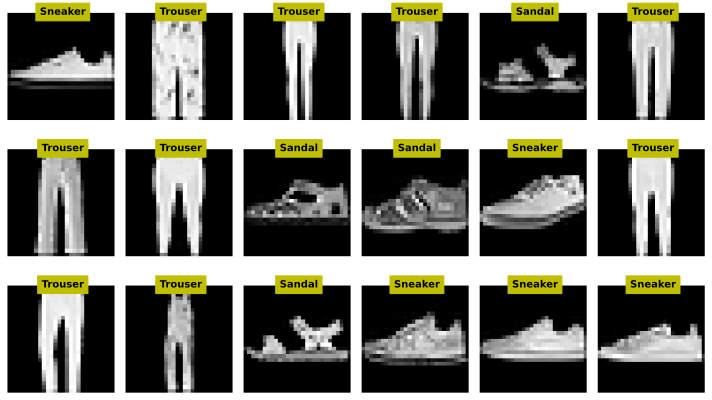

In [5]:
# view some images
# inspect a few random images

X,y = next(iter(data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [6]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4802],
        [0.4710],
        [0.4768],
        [0.4872],
        [0.4820],
        [0.4650],
        [0.4702],
        [0.4718],
        [0.5233],
        [0.4722]], grad_fn=<SigmoidBackward0>)

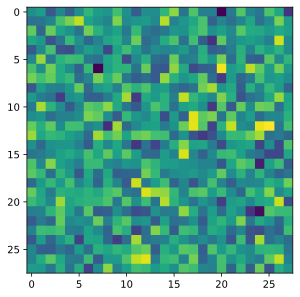

In [7]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models!

In [8]:
# loss function
lossfun = nn.BCELoss()

# create instances of the networks and push to the GPU
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# same algo but different instances for the G and D networks
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [9]:
# this cell takes ~13 mins with 50k batches
num_epochs = int(50000/len(data_loader))

losses = np.zeros((num_epochs*len(data_loader),2))
lossi  = 0

for epochi in range(num_epochs):

  for data,_ in data_loader:

    # send data to GPU
    data = data.view(batchsize,-1).to(device)


    # labels used for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator
    pred_fake   = dnet(fake_images)                            # pass through discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels)               # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[lossi,0] = d_loss.item()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,64).to(device) )
    pred_fake   = dnet(fake_images)

    # compute and collect loss
    g_loss = lossfun(pred_fake,real_labels)
    losses[lossi,1] = g_loss.item()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # increment loss counter
    lossi += 1


  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)


Finished epoch 277/277

In [10]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

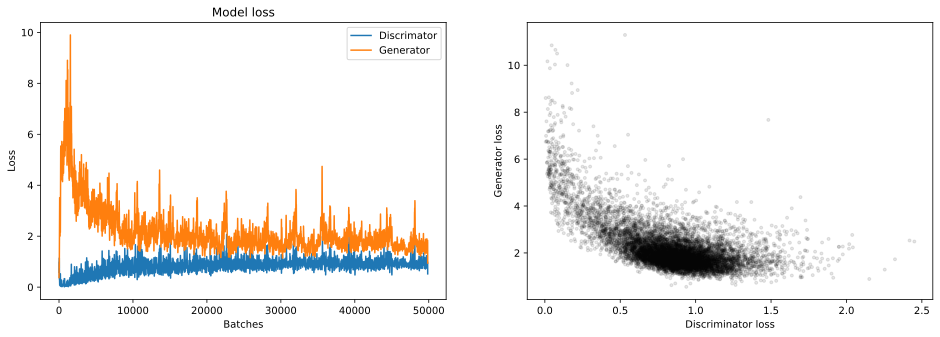

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,6000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show()

# Let's see some fake fashion!

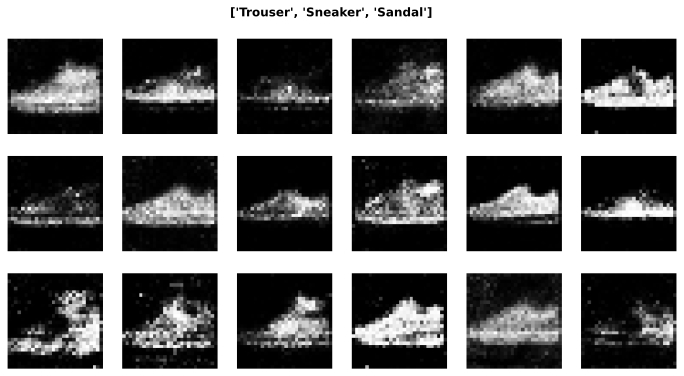

In [12]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.suptitle(classes2keep,y=.95,fontweight='bold')
plt.show()